<a href="https://colab.research.google.com/github/HepinR/Twitter-Sentiment-Project/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install keras

In [5]:
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

load all of data

In [8]:
train=pd.read_csv("/content/twitter_training.csv")
validation=pd.read_csv("/content/twitter_validation.csv")

As we can see there are no column name present in datasets so,



At first put name for each column:

In [9]:
train.columns=['Tweet ID','Entity','Sentiment','Tweet Content']
train.head()

Tweet ID       Entity Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                       Tweet Content  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...

In [10]:
validation.columns=['Tweet ID','Entity','Sentiment','Tweet Content']
validation.head()

Tweet ID     Entity Sentiment  \
0       352     Amazon   Neutral   
1      8312  Microsoft  Negative   
2      4371      CS-GO  Negative   
3      4433     Google   Neutral   
4      6273       FIFA  Negative   

                                       Tweet Content  
0  BBC News - Amazon boss Jeff Bezos rejects clai...  
1  @Microsoft Why do I pay for WORD when it funct...  
2  CSGO matchmaking is so full of closet hacking,...  
3  Now the President is slapping Americans in the...  
4  Hi @EAHelp I‚Äôve had Madeleine McCann in my cel...

In [11]:
train.info()
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       74681 non-null  int64 
 1   Entity         74681 non-null  object
 2   Sentiment      74681 non-null  object
 3   Tweet Content  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       999 non-null    int64 
 1   Entity         999 non-null    object
 2   Sentiment      999 non-null    object
 3   Tweet Content  999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


Check the null values of data:

In [12]:
train.isnull().sum()

Tweet ID           0
Entity             0
Sentiment          0
Tweet Content    686
dtype: int64

In [13]:
validation.isnull().sum()

Tweet ID         0
Entity           0
Sentiment        0
Tweet Content    0
dtype: int64

Check the duplicate values in data:

In [14]:
train.duplicated().sum()

2700

In [15]:
train.dropna(subset=['Tweet Content'], inplace=True)

In [16]:
duplicates = train[train.duplicated(subset=['Entity', 'Sentiment', 'Tweet Content'], keep=False)]
train = train.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet Content'], keep='first')

In [17]:
duplicates = validation[validation.duplicated(subset=['Entity', 'Sentiment', 'Tweet Content'], keep=False)]
validation = validation.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet Content'], keep='first')

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70957 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       70957 non-null  int64 
 1   Entity         70957 non-null  object
 2   Sentiment      70957 non-null  object
 3   Tweet Content  70957 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [19]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       999 non-null    int64 
 1   Entity         999 non-null    object
 2   Sentiment      999 non-null    object
 3   Tweet Content  999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


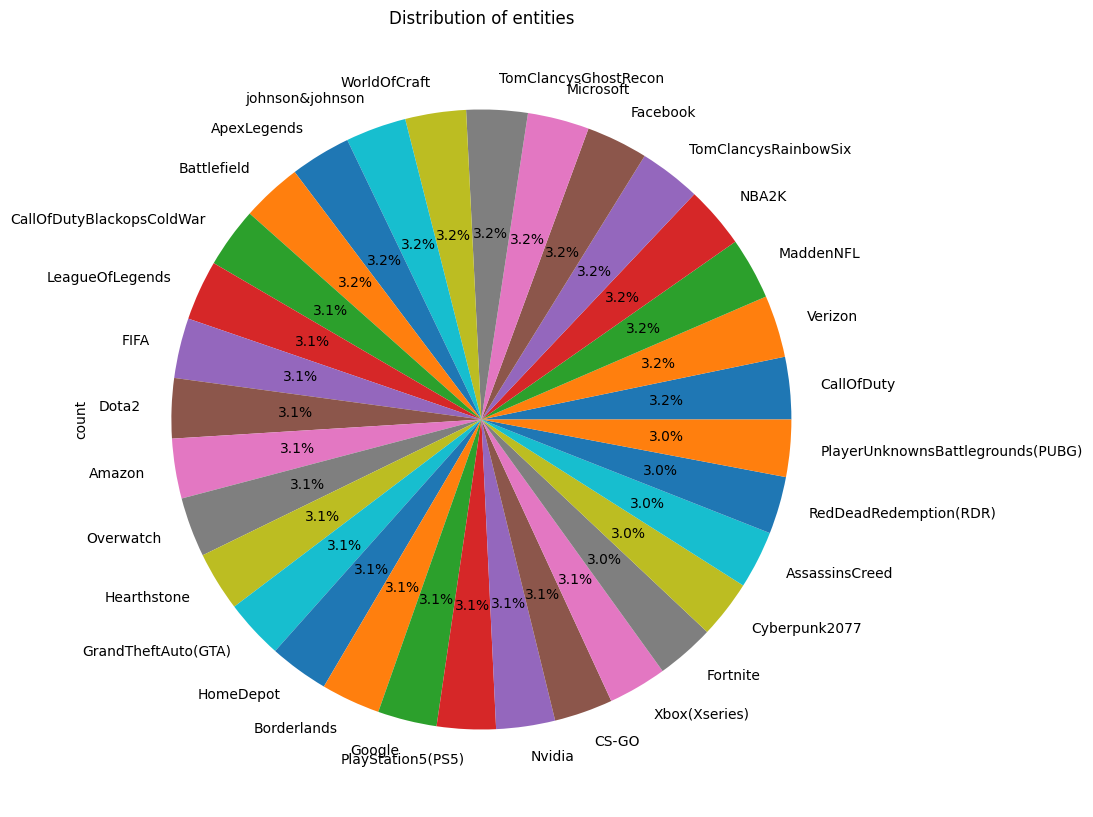

In [20]:
Entities=train['Entity'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 12))
plt.title('Distribution of entities')
plt.show()

Text(0.5, 1.0, 'Sentiment Distribution Train')

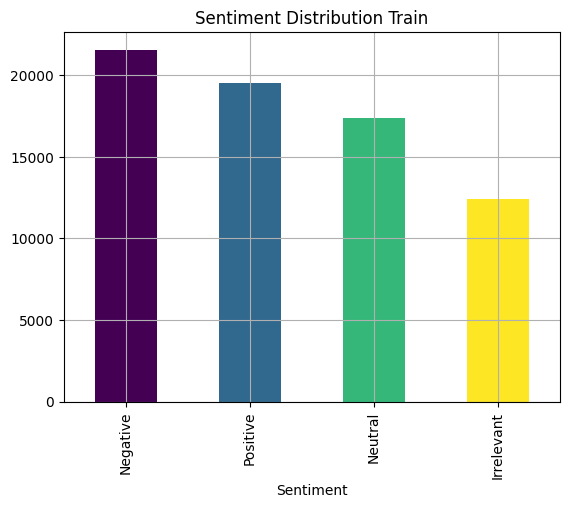

In [21]:
sentiment_content=train['Sentiment'].value_counts()
color=plt.get_cmap('viridis')
colors = [color(i) for i in np.linspace(0, 1, len(sentiment_content))]
sentiment_content.plot(kind='bar',color=colors,grid=True)
plt.title('Sentiment Distribution Train')

Text(0.5, 1.0, 'Sentiment Distribution Validation')

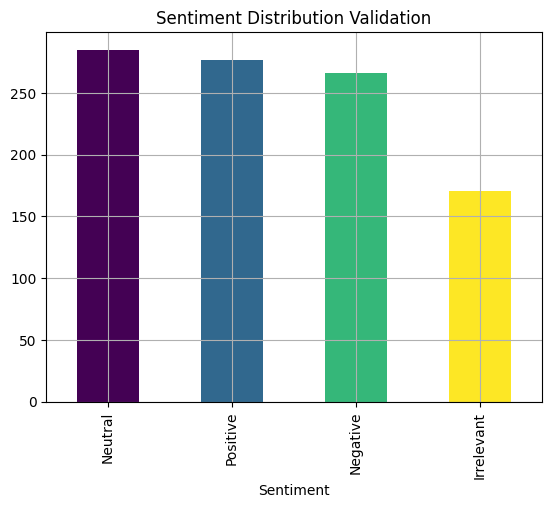

In [22]:
sentiment_content=validation['Sentiment'].value_counts()
color=plt.get_cmap('viridis')
colors = [color(i) for i in np.linspace(0, 1, len(sentiment_content))]
sentiment_content.plot(kind='bar',color=colors,grid=True)
plt.title('Sentiment Distribution Validation')

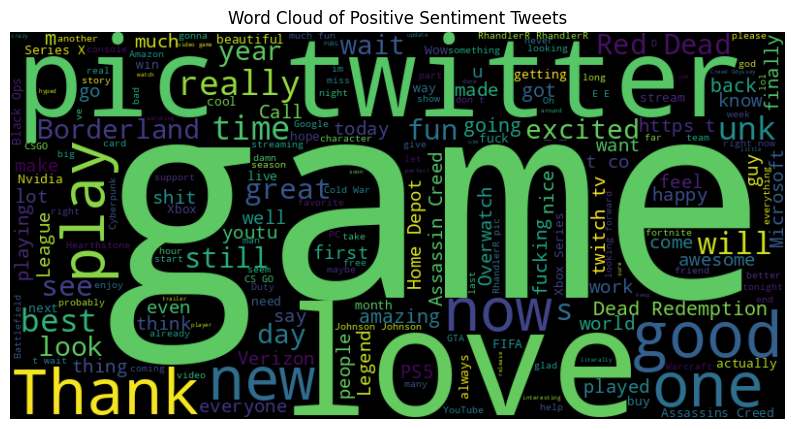

In [23]:
positive_tweets = train[train["Sentiment"] == "Positive"]["Tweet Content"]
positive_text = ' '.join(positive_tweets)
wordcloud = WordCloud(width=800, height=400).generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Sentiment Tweets')
plt.show()

Now count the frequency of each word from Word Cloud of positive sentiment tweets

In [24]:
from wordcloud import STOPWORDS
from collections import Counter

words = positive_text.split()
word_freq = Counter(word for word in words if word not in STOPWORDS)
top_words = word_freq.most_common(20)

top_words

[('I', 7817),
 ('.', 2394),
 ('/', 2363),
 ('@', 2336),
 ('game', 1562),
 ('The', 1392),
 ('love', 1291),
 ('really', 1113),
 ("I'm", 1088),
 ('good', 1071),
 ('-', 935),
 ('new', 927),
 ('2', 900),
 ('This', 880),
 ('play', 851),
 ('will', 828),
 ('best', 815),
 ('playing', 778),
 ('one', 740),
 ('3', 692)]

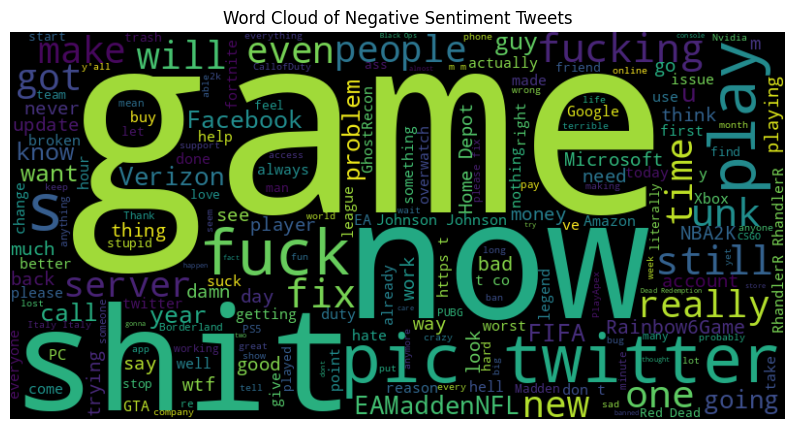

In [25]:
negative_tweets = train[train["Sentiment"] == "Negative"]["Tweet Content"]
negative_text = ' '.join(negative_tweets)
wordcloud = WordCloud(width=800, height=400).generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Sentiment Tweets')
plt.show()

In [26]:
words = negative_text.split()
word_freq = Counter(word for word in words if word not in STOPWORDS)
top_words = word_freq.most_common(20)

top_words

[('I', 8533),
 ('@', 4619),
 ('game', 2777),
 ('/', 2246),
 ('.', 1527),
 ('The', 1083),
 ('shit', 1052),
 ('fix', 1030),
 ('play', 997),
 ('still', 953),
 ('‚Äô', 943),
 ('now', 940),
 ('fucking', 866),
 ('will', 866),
 ('really', 865),
 ('even', 861),
 ('This', 837),
 ('&', 834),
 ('got', 787),
 ('one', 784)]

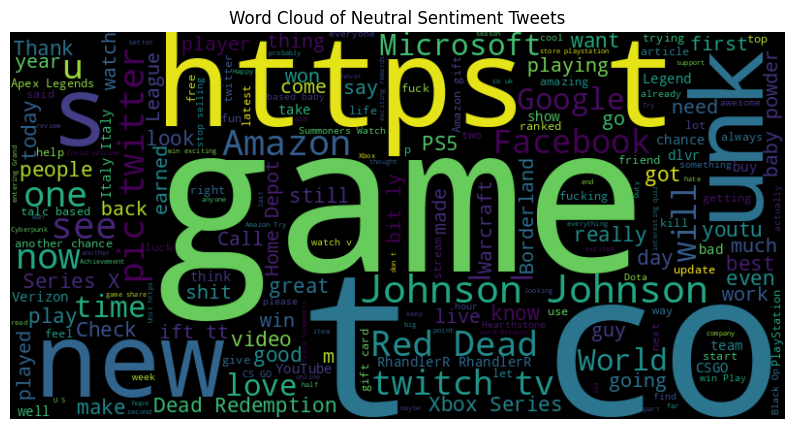

In [27]:
neutral_tweets = train[train["Sentiment"] == "Neutral"]["Tweet Content"]
neutral_text = ' '.join(neutral_tweets)
wordcloud = WordCloud(width=800, height=400).generate(neutral_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Neutral Sentiment Tweets')
plt.show()

In [28]:
words = neutral_text.split()
word_freq = Counter(word for word in words if word not in STOPWORDS)
top_words = word_freq.most_common(20)

top_words

[('/', 7444),
 ('I', 4647),
 ('.', 3501),
 ('@', 2354),
 ('-', 2291),
 ('Johnson', 1630),
 ('The', 1590),
 ('&', 1363),
 ('_', 1050),
 ('2', 955),
 ('Amazon', 804),
 ('game', 768),
 ('will', 719),
 ('now', 615),
 ('A', 587),
 ('‚Ä¶', 587),
 ('Facebook', 565),
 ("I'm", 556),
 ('see', 539),
 ('Microsoft', 537)]

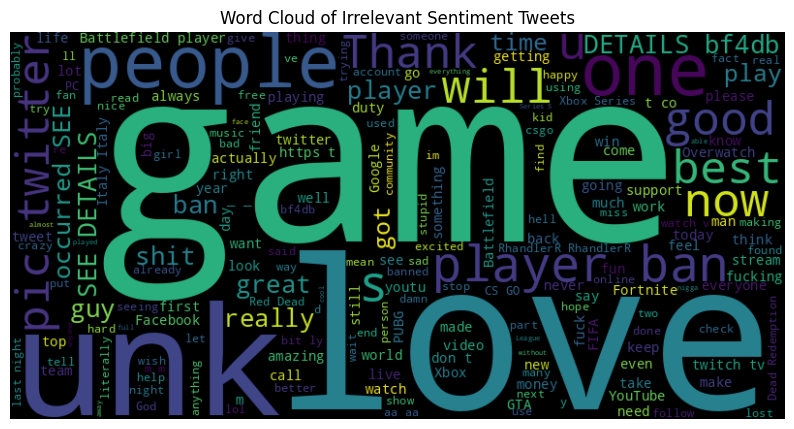

In [29]:
Irrelevant_tweets = train[train["Sentiment"] == "Irrelevant"]["Tweet Content"]
Irrelevant_text = ' '.join(Irrelevant_tweets)
wordcloud = WordCloud(width=800, height=400).generate(Irrelevant_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Irrelevant Sentiment Tweets')
plt.show()

In [30]:
words = Irrelevant_text.split()
word_freq = Counter(word for word in words if word not in STOPWORDS)
top_words = word_freq.most_common(20)

top_words

[('I', 3691),
 ('/', 2537),
 ('.', 2238),
 ('@', 1667),
 ('The', 878),
 ('player', 786),
 ('A', 674),
 ('ban', 674),
 ('-', 659),
 ('people', 599),
 ('_', 588),
 ('4', 557),
 ('This', 544),
 ('will', 540),
 ('game', 519),
 ('one', 510),
 ('love', 505),
 ("I'm", 489),
 ('see', 487),
 ('Battlefield', 478)]

In [31]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

Train Test Split

In [32]:
data = train[['Tweet Content', 'Sentiment']]
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])
data['Sentiment'] = data['Sentiment_label'].cat.codes

data_train, data_test = train_test_split(data, test_size = 0.1)

data_train.head(10)

<ipython-input-32-e3954e870d4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment_label'] = pd.Categorical(data['Sentiment'])
<ipython-input-32-e3954e870d4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment'] = data['Sentiment_label'].cat.codes


Tweet Content  Sentiment  \
41903     The Russian bots are aggravating Battlefield 1          2   
54406  to wazone plunder should be made a real perman...          3   
10410                                             Damned          0   
18766  I just earned an [Halls Against Devotion] Achi...          2   
73698  Shout out to everyone whose RTX 20x0 GPUs have...          2   
38124           My power over you will be even stronger.          3   
10658  How many of you will bought the season 6 survi...          0   
71300  @GhostRecon How do we fix the Cursor issue, no...          1   
63017  My boy got the cannon but his accuracy shaky a...          2   
50521  Why no one wants to sign for my @ FGRFC _ Offi...          1   

      Sentiment_label  
41903         Neutral  
54406        Positive  
10410      Irrelevant  
18766         Neutral  
73698         Neutral  
38124        Positive  
10658      Irrelevant  
71300        Negative  
63017         Neutral  
50521        Negative

In [33]:
data_test.head(10)

Tweet Content  Sentiment  \
65500  if they're going in vigorously defend their pr...          1   
3066   It looks like Call of Duty: Black Ops Cold War...          1   
65407  Not Johnson & Johnson with ads about how they ...          2   
1686   New Deal (Epic Store Free Games release schedu...          2   
67525             For the love of God, people, PRAYER...          0   
63454                                       people curse          2   
55509  2 Looking back out on old files on playing a h...          2   
74235  Nvidia does some shady shit, but you gotta giv...          2   
57667  Fix you fucking shit game ubi @ Rainbow6Game @...          1   
62393  Omo the way i dey abuse cars for this GTA no b...          2   

      Sentiment_label  
65500        Negative  
3066         Negative  
65407         Neutral  
1686          Neutral  
67525      Irrelevant  
63454         Neutral  
55509         Neutral  
74235         Neutral  
57667        Negative  
62393         Neutral

BERT

In [41]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 471.6/471.6 kB 25.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 194.1/194.1 kB 18.0 MB/s eta 0:00:00


In [51]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_dataset = data_train
test_dataset = data_test
train_dataset['labels'] = train_dataset['Sentiment']
test_dataset['labels'] = test_dataset['Sentiment']

# Load the tokenizer and model
model_name = "bert-base-uncased"  # Pre-trained BERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=data['Sentiment_label'].nunique())

# Tokenize the dataset
def tokenize_function(examples):
    tokenized = tokenizer(examples['Tweet Content'], padding="max_length", truncation=True, max_length=128)
    tokenized['labels'] = examples['Sentiment']
    return tokenized

# Convert Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_dataset)
test_dataset = Dataset.from_pandas(test_dataset)
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels']) # Changed 'Sentiment' to 'labels'
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels']) # Changed 'Sentiment' to 'labels'

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tune the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/63861 [00:00<?, ? examples/s]

Map:   0%|          | 0/7096 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=23949, training_loss=0.39311011536511764, metrics={'train_runtime': 5525.6696, 'train_samples_per_second': 34.671, 'train_steps_per_second': 4.334, 'total_flos': 1.2602127624532992e+16, 'train_loss': 0.39311011536511764, 'epoch': 3.0})

In [53]:
trainer.save_model('./finetuned_sentiment_model')
tokenizer.save_pretrained('./finetuned_sentiment_model')

('./finetuned_sentiment_model/tokenizer_config.json',
 './finetuned_sentiment_model/special_tokens_map.json',
 './finetuned_sentiment_model/vocab.txt',
 './finetuned_sentiment_model/added_tokens.json',
 './finetuned_sentiment_model/tokenizer.json')

In [54]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.3151226341724396, 'eval_runtime': 47.0679, 'eval_samples_per_second': 150.761, 'eval_steps_per_second': 18.845, 'epoch': 3.0}


In [55]:
import numpy as np
from sklearn.metrics import accuracy_score

eval_result = trainer.evaluate()
predictions = trainer.predict(test_dataset)

In [56]:
logits, labels, _ = predictions
predicted_classes = np.argmax(logits, axis=-1)
accuracy = accuracy_score(labels, predicted_classes)

print(f"Accuracy: {accuracy:.4f}")
print(eval_result)

Accuracy: 0.9350
{'eval_loss': 0.3151226341724396, 'eval_runtime': 45.6212, 'eval_samples_per_second': 155.542, 'eval_steps_per_second': 19.443, 'epoch': 3.0}


# We achieved 93.5% accuracy

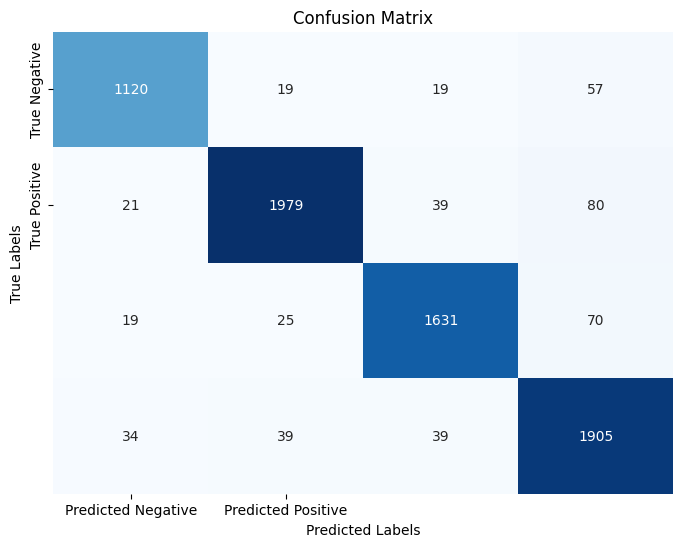

In [57]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [59]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()

    return predicted_class

# Example prediction
example_text = "I will murder you all"
print(predict_sentiment(example_text))


3
